# Explore the connectivity structure for fast synapse computation

In [1]:
import time
import numpy as np
import numba as nb

import npbrain as nn

In [2]:
def run(f, num=10, *args):
    t0 = time.time()
    for _ in range(num):
        f(*args)
    t1 = time.time()
    return t1 - t0

Let's first generate the connection between two neuron groups.

In [3]:
N = pre_num = post_num = 5000
pre_indexes, post_indexes, pre_anchors = nn.conn.fixed_prob(N, N, 0.1)
conn_mat = np.zeros((N, N))
conn_mat[pre_indexes, post_indexes] = 1.

pre_spike = np.zeros(N)
spike_idx = np.random.randint(0, N, 1000)
pre_spike[spike_idx] = 1.

## Method 1

The first method is to use `np.dot` to compute spike numbers for each post-synaptic neuron.

In [4]:
def np_syn1(pre_spike, conn_mat):
    return np.dot(pre_spike, conn_mat)

In [5]:
@nb.njit
def nb_syn1(pre_spike, conn_mat):
    return np.dot(pre_spike, conn_mat)

In [6]:
run_num = 1000
time_np_syn1 = run(np_syn1, run_num, pre_spike, conn_mat)
print('np_syn1 : {} s'.format(time_np_syn1))
time_nb_syn1 = run(nb_syn1, run_num, pre_spike, conn_mat)
print('nb_syn1 : {} s'.format(time_nb_syn1))

np_syn1 : 10.173325538635254 s
nb_syn1 : 10.199754238128662 s


The advantage of this method is that it can use the auto-parallelism of `np.dot` method. 
However, when the `pre_spike` is highly sparse, or, none of pre-synaptic neuron produces spike,
this method will waste too much time to compute useless and trivial results.The complexity of 
this method is O(`pre_num`) * O(`pre_num`) * O(`post_num`).

## Method 2

The second method is to use `dict` data structure to accommodate the correspondence between 
pre-synaptic neurons and post-synaptic neurons. This method is intutive, becanse whenever you
want to get the `post-synaptic neuron indeces`, you can directly call `pre2post_dict[pre_idx]`.

So, let's first generate the corresponding data structure.

In [7]:
def correspondence(num_pre, num_post, i, j):
    assert len(i) == len(j)
    pre_indexes = {i_: [] for i_ in range(num_pre)}
    post_indexes = {j_: [] for j_ in range(num_post)}
    for index, i_ in enumerate(i):
        i_ = i_
        j_ = j[index]
        pre_indexes[i_].append(index)
        post_indexes[j_].append(index)
    return pre_indexes, post_indexes

In [8]:
pre2syn, post2syn = correspondence(N, N, pre_indexes, post_indexes)
pre2syn = [v for _, v in sorted(pre2syn.items())]
post2syn = [v for _, v in sorted(post2syn.items())]

In [9]:
def np_syn2():
    syn_val = np.zeros((len(post_indexes),))
    for i_ in spike_idx:
        syn_val[pre2syn[i_]] = 1.
    post_val = np.zeros(N)
    for i, j_ in enumerate(post2syn):
        post_val[i] = np.sum(syn_val[j_])

In [10]:
time_np_syn2 = run(np_syn2, run_num // 10)
print('np_syn2 : {} s'.format(time_np_syn2))

np_syn2 : 23.630071878433228 s


As you can see, this method is higly computation ineffective. More importantly, this method cannot be accelerated by `Numba` technology, for `dict` is not well supported in `Numba`.

## Method 3

The third method is use `tuple` or `list` structure to accommodate the correspondence 
between pre-synaptic neurons and post-synaptic neurons.

For `pre2post` object, the first position `pre2post[0]` retrives the post-synaptic neurons 
connected with pre-neuron 0.

Similarly, `post2pre` object contains the pre-synaptic neuron indices corresponding to the 
post-synaptic neurons. Get the pre-neurons connectd to post-neuron `x`, you can directly 
call `post2pre[x]`.

In [11]:
pre2post = [np.where(conn_mat[i] > 0.)[0] for i in range(N)]
post2pre = [np.where(conn_mat[:, i] > 0.)[0] for i in range(N)]

In [12]:
def np_syn3(post_num, pre_spike, post2pre):
    post_val = np.zeros(post_num)
    for i in range(post_num):
        post_val[i] = np.sum(pre_spike[post2pre[i]])
    return post_val

In [13]:
time_np_syn3 = run(np_syn3, run_num, post_num, pre_spike, post2pre)
print('np_syn3 : {} s'.format(time_np_syn3))

np_syn3 : 23.910284757614136 s


In general terms, this kind of data structure can be highly effective. However, when the user 
greedily interates `post_num`, too much time will be wasted on the neurons which do not produce 
spikes. So, this method is not a good choice. 

## Method 4

Instead of grid-search the post-synpatic neurons, we use the pre-synpatic neuron which produce spikes.
When one neuron produces a spike, we retrive its connected post-synaptic neurons, and add a spike-induced
value to the post-neurons. 

In [14]:
def np_syn4(post_num, pre_spike, pre2post):
    post_val = np.zeros(post_num)
    spike_idx = np.where(pre_spike > 0)[0]
    for i in spike_idx:
        post_idx = pre2post[i]
        post_val[post_idx] += 1
    return post_val

In [15]:
time_np_syn4 = run(np_syn4, run_num, post_num, pre_spike, pre2post)
print('np_syn4 : {} s'.format(time_np_syn4))

np_syn4 : 3.36203932762146 s


As you can see, this method is highly efficient for synapse computation. 

However, its problem is the data structure of `pre2post` or `post2pre` is hard
to be compiled by Numba. As you can see in the follows:

In [16]:
pre2post_nb = [nb.typed.List(l) if len(l) else nb.typed.List.empty_list(nb.types.int64) 
               for l in pre2post]

In [17]:
@nb.njit
def nb_syn4(post_num, pre_spike, pre2post):
    post_val = np.zeros(post_num)
    spike_idx = np.where(pre_spike > 0)[0]
    for i in spike_idx:
        post_idx = pre2post[i]
        for j in post_idx:
            post_val[j] += 1
    return post_val

In [18]:
time_nb_syn4 = run(nb_syn4, run_num, post_num, pre_spike, pre2post_nb)
print('nb_syn4 : {} s'.format(time_nb_syn4))

C:\Users\oujag\miniconda3\envs\py37\lib\site-packages\numba\core\ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'pre2post' of function 'nb_syn4'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-17-1bb2fc91feb5>", line 2:
@nb.njit
def nb_syn4(post_num, pre_spike, pre2post):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


nb_syn4 : 30.053535223007202 s


In [19]:
time_nb_syn4 = run(nb_syn4, run_num, post_num, pre_spike, pre2post_nb)
print('nb_syn4 again : {} s'.format(time_nb_syn4))

nb_syn4 again : 29.35871648788452 s


## Method 5

An alternative way is to use `numpy array` to wrap the pre2post or post2pre correspondence.
For example, 1-D array `pre_indexes` presents the connected pre-synaptic neurons, 
1-D array `post_indexes` denotes the connected post-synaptic neurons. This means
`(pre_indexes[x], post_indexes[x])` is a pair of connected neurons. 
In order to conveniently get post-indices by a pre-synaptic id, we can also contruct a 2-D 
array `pre_anchors` with the dimension of `(2, num_pre)`. `num_pre` is the number of the 
pre-synaptic neurons, and `2` is the `start` and the `end` positions in the `post_indexes`. 
`idx = pre_anchors[x]` extracts the start and end position of `post_indexes`.

Let's see our experimental results:

In [20]:
def np_syn5(post_num, pre_spike, post_indexes, pre_anchors):
    post_val = np.zeros(post_num)
    spike_idx = np.where(pre_spike > 0)[0]
    for i_ in spike_idx:
        index = pre_anchors[:, i_]
        post_idx = post_indexes[index[0]: index[1]]
        post_val[post_idx] += 1
    return post_val

In [21]:
time_np_syn5 = run(np_syn5, run_num, post_num, pre_spike, post_indexes, pre_anchors)
print('np_syn5 : {} s'.format(time_np_syn5))

np_syn5 : 8.672416687011719 s


In [22]:
def np_syn5_2(post_num, pre_spike, post_indexes, pre_anchors):
    post_val = np.zeros(post_num)
    spike_idx = np.where(pre_spike > 0)[0]
    for i_ in spike_idx:
        start, end = pre_anchors[:, i_]
        post_idx = post_indexes[start: end]
        post_val[post_idx] += 1
    return post_val

In [23]:
time_np_syn5_2 = run(np_syn5_2, run_num, post_num, pre_spike, post_indexes, pre_anchors)
print('np_syn5_2 : {} s'.format(time_np_syn5_2))

np_syn5_2 : 9.610430240631104 s


In [24]:
@nb.njit
def nb_syn5(post_num, pre_spike, post_indexes, pre_anchors):
    post_val = np.zeros(post_num)
    spike_idx = np.where(pre_spike > 0)[0]
    for i_ in spike_idx:
        index = pre_anchors[:, i_]
        post_idx = post_indexes[index[0]: index[1]]
        post_val[post_idx] += 1
    return post_val

In [25]:
time_nb_syn5 = run(nb_syn5, run_num, post_num, pre_spike, post_indexes, pre_anchors)
print('nb_syn5 : {} s'.format(time_nb_syn5))

nb_syn5 : 1.1200363636016846 s


As you can see, the kind of synaptic data sturcture is highly efficient. Most importantly, 
it can be accelerated by Numba.

## Systermatic comparison

Finnaly, let's synatermically compare the different synaptic data structures under 
the different number of pre-synaptic spikes.

In [26]:
def single_run(num_spike_neuron, pre_num=5000, post_num=5000):
    pre_indexes, post_indexes, pre_anchors = nn.conn.fixed_prob(pre_num, post_num, 0.1)
    conn_mat = np.zeros((pre_num, post_num))
    conn_mat[pre_indexes, post_indexes] = 1.
    
    pre2post = [np.where(conn_mat[i] > 0.)[0] for i in range(N)]
    post2pre = [np.where(conn_mat[:, i] > 0.)[0] for i in range(N)]

    pre_spike = np.zeros(pre_num)
    spike_idx = list(range(num_spike_neuron))
    pre_spike[spike_idx] = 1.
    
    time_np_syn1 = run(np_syn1, run_num, pre_spike, conn_mat)
    time_nb_syn1 = run(nb_syn1, run_num, pre_spike, conn_mat)
    time_np_syn3 = run(np_syn3, run_num, post_num, pre_spike, post2pre)
    time_np_syn4 = run(np_syn4, run_num, post_num, pre_spike, pre2post)
    time_np_syn5 = run(np_syn5, run_num, post_num, pre_spike, post_indexes, pre_anchors)
    time_nb_syn5 = run(nb_syn5, run_num, post_num, pre_spike, post_indexes, pre_anchors)
    
    return time_np_syn1, time_nb_syn1, time_np_syn3, time_np_syn4, time_np_syn5, time_nb_syn5

In [27]:
import matplotlib.pyplot as plt

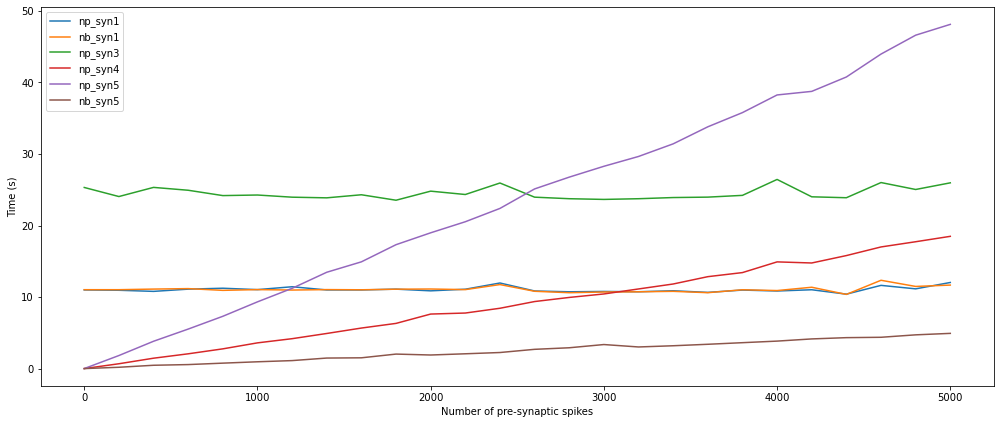

In [28]:
all_num_pre_spike = list(range(0, 5000+1, 200))
all_np_syn1 = []
all_nb_syn1 = []
all_np_syn3 = []
all_np_syn4 = []
all_np_syn5 = []
all_nb_syn5 = []
for num in all_num_pre_spike:
    res = single_run(num)
    all_np_syn1.append(res[0])
    all_nb_syn1.append(res[1])
    all_np_syn3.append(res[2])
    all_np_syn4.append(res[3])
    all_np_syn5.append(res[4])
    all_nb_syn5.append(res[5])

plt.figure(figsize=(14, 6))
plt.plot(all_num_pre_spike, all_np_syn1, label='np_syn1')
plt.plot(all_num_pre_spike, all_nb_syn1, label='nb_syn1')
plt.plot(all_num_pre_spike, all_np_syn3, label='np_syn3')
plt.plot(all_num_pre_spike, all_np_syn4, label='np_syn4')
plt.plot(all_num_pre_spike, all_np_syn5, label='np_syn5')
plt.plot(all_num_pre_spike, all_nb_syn5, label='nb_syn5')
plt.legend()
plt.ylabel('Time (s)')
plt.xlabel('Number of pre-synaptic spikes')
plt.tight_layout()
plt.show()